<a href="https://colab.research.google.com/github/kkkaeun/AImodel/blob/main/Capstone%20AImodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Conv1D
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
tf.compat.v1.keras.backend.clear_session()
disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [107]:
df_Course = pd.read_csv('/content/sample_data/120115_robot/ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS = pd.read_csv('/content/sample_data/120115_robot/nedgps.csv', header = None, names = ['Latitude', 'Longitude', 'Altitude'])
total_timestamps = len(df_GPS)
window_size = 60
start_point = 5
num_windows = total_timestamps - window_size + 1 - start_point

df = df_GPS.iloc[start_point:total_timestamps]
data = df[['Latitude', 'Longitude', 'Altitude']]

df_Accel = pd.read_csv('/content/sample_data/120115_robot/nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df = df_Accel.iloc[start_point:total_timestamps]
data['Accel_x_NED'] = df['Accel_x_NED']
data['Accel_y_NED'] = df['Accel_y_NED']
data['Accel_z_NED'] = df['Accel_z_NED']

df_Euler = pd.read_csv('/content/sample_data/120115_robot/nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df = df_Euler.iloc[start_point:total_timestamps]
data['Euler_x'] = df['Euler_x']
data['Euler_y'] = df['Euler_y']
data['Euler_z'] = df['Euler_z']

df = df_Course.iloc[start_point:total_timestamps]
data['Gyro_x'] = df['Gyro_x']
data['Gyro_y'] = df['Gyro_y']
data['Gyro_z'] = df['Gyro_z']
data.tail()

,Latitude,Longitude,Altitude,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
320091,-1.6864,-2.4968,3.3991,-0.14228,-0.011752,9.8092,-135.81,0.006030,-0.67141,-0.004698,0.000619,-0.008716
320092,-1.6864,-2.4968,3.3991,-0.14165,-0.011759,9.8092,-135.82,0.007374,-0.66800,-0.002714,-0.005613,-0.001590
320093,-1.6863,-2.4968,3.3992,-0.14166,-0.012048,9.8092,-135.81,0.005780,-0.66744,-0.001513,-0.004799,0.004491
320094,-1.6861,-2.4968,3.3995,-0.14030,-0.013310,9.8093,-135.80,0.001955,-0.65727,-0.002847,-0.013433,0.005820
320095,-1.6858,-2.4967,3.4000,-0.13900,-0.016845,9.8093,-135.78,-0.014323,-0.64249,-0.002012,-0.008011,0.008690


In [90]:
#정답 레이블을 위한 GPS 변화량 데이터 만들기
delta_data = data.diff(axis=0)
delta_latitude = delta_data['Latitude']
delta_longitude = delta_data['Longitude']
delta_altitude = delta_data['Altitude']

shifted = delta_data[['Latitude', 'Longitude', 'Altitude']].copy()

shifted['Pred_Lat'] = shifted['Latitude'].shift(-window_size)
shifted['Pred_Lon'] = shifted['Longitude'].shift(-window_size)
shifted['Pred_Alt'] = shifted['Altitude'].shift(-window_size)

shifted['Pred_Lat'].fillna(method='ffill', inplace = True)
shifted['Pred_Lon'].fillna(method='ffill', inplace = True)
shifted['Pred_Alt'].fillna(method='ffill', inplace = True)

In [91]:
train_X = data[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED',  'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X = train_X.astype(np.float32)

windowed_data = np.zeros((num_windows, window_size, 9), dtype = np.float32)

for i in range(num_windows):
    windowed_data[i] = train_X[i:i+window_size]

train_y=shifted[['Pred_Lat', 'Pred_Lon', 'Pred_Alt']][:num_windows]

x_data = windowed_data
x_data = np.array(x_data)
y_data = train_y.values

print(x_data.shape)
print(y_data.shape)

(320032, 60, 9)
(320032, 3)


In [92]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

sc = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d = x_data.reshape(-1, x_data.shape[-1])
y_data_2d = y_data.reshape(-1, y_data.shape[-1])

# 스케일링 적용
new_x_data_2d = sc.fit_transform(x_data_2d)
new_y_data_2d = sc.fit_transform(y_data_2d)

# 다시 3D로 변환
new_x_data = new_x_data_2d.reshape(x_data.shape)
new_y_data = new_y_data_2d.reshape(y_data.shape)

# train-test split
x_train, x_val, y_train, y_val = train_test_split(new_x_data, new_y_data, test_size=0.33, shuffle=True, random_state=42)

print(new_x_data.shape)
print(new_y_data.shape)

(320032, 60, 9)
(320032, 3)


In [120]:
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling1D

def Single_model():
    inp = Input(shape=(60, 9))
    x = Conv1D(filters=64, kernel_size=1, padding="causal", activation="relu", strides=1)(inp)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=128, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=256, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = Conv1D(filters=512, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'valid')(x)
    x = GRU(32, activation="tanh")(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation="linear")(x)

    model = Model(inputs=inp, outputs=output)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.summary()

    return model

if __name__ == "__main__":
    model = Single_model()

    history = model.fit(x_train, y_train, batch_size = 1024, epochs=10, validation_data=(x_val, y_val))

    y_pred = model.predict(x_val)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 9)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 60, 64)            640       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 128)           8320      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 15, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 15, 256)           3302

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


214421/214421 [==============================] - 141s 657us/sample - loss: 0.0012 - mae: 0.0226 - val_loss: 9.4120e-05 - val_mae: 0.0042
Epoch 2/10
214421/214421 [==============================] - 143s 666us/sample - loss: 4.2055e-04 - mae: 0.0137 - val_loss: 6.1861e-05 - val_mae: 0.0021
Epoch 3/10
214421/214421 [==============================] - 141s 657us/sample - loss: 2.6129e-04 - mae: 0.0099 - val_loss: 5.8487e-05 - val_mae: 0.0016
Epoch 4/10
214421/214421 [==============================] - 173s 809us/sample - loss: 1.7363e-04 - mae: 0.0074 - val_loss: 5.6815e-05 - val_mae: 0.0013
Epoch 5/10
214421/214421 [==============================] - 181s 843us/sample - loss: 1.2146e-04 - mae: 0.0054 - val_loss: 5.5569e-05 - val_mae: 9.6954e-04
Epoch 6/10
214421/214421 [==============================] - 144s 674us/sample - loss: 9.0020e-05 - mae: 0.0039 - val_loss: 5.4907e-05 - val_mae: 7.6982e-04
Epoch 7/10
214421/214421 [==============================] - 163s 762us/sample - loss: 7.2976e-0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


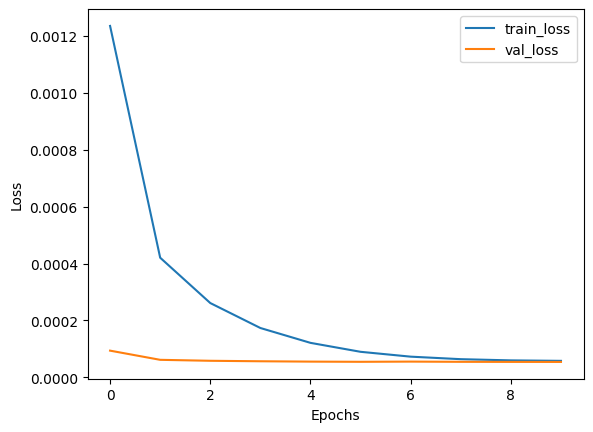

In [121]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test 1. 3535 data

In [122]:
df_GPS1 = pd.read_csv('/content/sample_data/3535/gps_NED.csv', header=None, names=['Latitude', 'Longitude', 'Altitude'])
test_timestamps = 130
test_start = 1600
df1 = df_GPS1.iloc[test_start:test_start + test_timestamps]
data1 = df1[['Latitude', 'Longitude', 'Altitude']]

df_AccelNED1 = pd.read_csv('/content/sample_data/3535/acc_NED.csv', header=None, names=['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df1 = df_AccelNED1.iloc[test_start:test_start + test_timestamps]
df1 = df1[['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED']]
data1['Accel_x_NED'] = df1[['Accel_x_NED']]
data1['Accel_y_NED'] = df1[['Accel_y_NED']]
data1['Accel_z_NED'] = df1[['Accel_z_NED']]

df_angvel1 = pd.read_csv('/content/sample_data/3535/sensorlog_angvel_20240226_163204.csv')
df1 = df_angvel1.iloc[test_start:test_start + test_timestamps]
data1['Gyro_x'] = df1['X']
data1['Gyro_y'] = df1['Y']
data1['Gyro_z'] = df1['Z']

df_euler1 = pd.read_csv('/content/sample_data/3535/euler_NED.csv', header=None, names=['Euler_0', 'Euler_1', 'Euler_2'])
df1 = df_euler1.iloc[test_start:test_start + test_timestamps]
df1 = df1[['Euler_0', 'Euler_1', 'Euler_2']]
data1['Euler_0'] = df1[['Euler_0']]
data1['Euler_1'] = df1[['Euler_1']]
data1['Euler_2'] = df1[['Euler_2']]

data1.reset_index(drop=True, inplace=True)
data1

,Latitude,Longitude,Altitude,Accel_x_NED,Accel_y_NED,Accel_z_NED,Gyro_x,Gyro_y,Gyro_z,Euler_0,Euler_1,Euler_2
0,-401.51,-717.33,9.792,6.11370,-0.057818,0.23392,0.131555,-0.277226,0.248728,-9.9764,13.9650,-139.53
1,-402.62,-715.48,9.920,-0.80157,-1.350500,7.80020,-0.036078,-0.404664,0.254183,-9.8726,12.5480,-140.29
2,-402.62,-714.55,9.427,-1.44020,-8.702400,-8.29330,0.736006,-0.173758,1.197050,-14.9960,9.2847,-142.69
3,-401.51,-713.62,9.038,8.66990,2.315800,2.10230,0.006396,0.333243,-0.011080,-65.0830,13.9900,-145.51
4,-401.51,-713.62,8.993,-12.12100,-1.052500,-1.20050,0.490602,-0.073202,-0.294406,-97.2230,10.8160,-143.22
...,...,...,...,...,...,...,...,...,...,...,...,...
125,-323.87,-630.92,9.350,5.96970,-4.736900,-3.96650,0.367902,0.331210,-0.651628,173.2800,8.8152,-138.55
126,-321.65,-630.92,9.444,6.28140,2.383900,-7.60150,0.327013,-0.003682,0.919282,179.0800,8.9529,-140.49
127,-320.54,-630.92,9.304,-2.14310,-5.570300,-10.30100,-0.598942,0.324268,0.287503,-178.7800,9.6835,-138.40
128,-319.43,-629.99,9.368,4.22600,-0.964230,9.59430,-0.059506,0.527191,0.269246,179.0100,12.6390,-136.68


In [123]:
delta_data1 = data1.diff(axis=0)
delta_latitude1 = delta_data1['Latitude']
delta_longitude1 = delta_data1['Longitude']
delta_altitude1 = delta_data1['Altitude']

shifted1 = delta_data1[['Latitude', 'Longitude', 'Altitude']].copy()
shifted1['Pred_Lat'] = shifted1['Latitude'].shift(-window_size)
shifted1['Pred_Lon'] = shifted1['Longitude'].shift(-window_size)
shifted1['Pred_Alt'] = shifted1['Altitude'].shift(-window_size)

shifted1['Pred_Lat'].fillna(method='ffill', inplace = True)
shifted1['Pred_Lon'].fillna(method='ffill', inplace = True)
shifted1['Pred_Alt'].fillna(method='ffill', inplace = True)

In [124]:
train_X1 = data1[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_0', 'Euler_1', 'Euler_2', 'Gyro_x', 'Gyro_y', 'Gyro_z']]

num_windows1 = test_timestamps - window_size + 1

windowed_data1 = np.zeros((num_windows1, window_size, 9))

for i in range(num_windows1):
    windowed_data1[i] = train_X1[i:i+window_size]

train_y1=shifted1[['Pred_Lat', 'Pred_Lon', 'Pred_Alt']][:num_windows1]

test1_x_data = windowed_data1
test1_x_data = np.array(test1_x_data)
test1_y_data = train_y1.values

print(test1_x_data.shape)
print(test1_y_data.shape)

(71, 60, 9)
(71, 3)


In [125]:
test1_sc = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
test1_x_data_2d = test1_x_data.reshape(-1, test1_x_data.shape[-1])
test1_y_data_2d = test1_y_data.reshape(-1, test1_y_data.shape[-1])

# 스케일링 적용
test1_new_x_data_2d = test1_sc.fit_transform(test1_x_data_2d)
test1_new_y_data_2d = test1_sc.fit_transform(test1_y_data_2d)

# 다시 3D로 변환
test1_new_x_data = test1_new_x_data_2d.reshape(test1_x_data.shape)
test1_new_y_data = test1_new_y_data_2d.reshape(test1_y_data.shape)

print(test1_new_x_data.shape)
print(test1_new_y_data.shape)

(71, 60, 9)
(71, 3)


In [126]:
if __name__ == "__main__":

    y_pred1 = model.predict(test1_new_x_data)

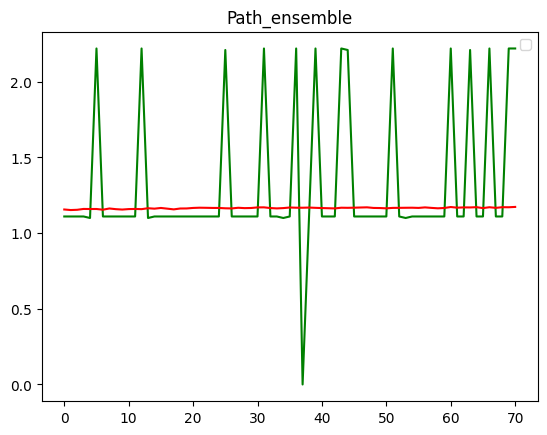

In [277]:
import numpy as np

test1_y_preds_array = np.array(y_pred1)
test1_new_y1_data_array = np.array(test1_new_y_data)

# 3차원 배열을 2차원 배열로 변환
test1_y_preds_flat = test1_y_preds_array.reshape(-1, test1_y_preds_array.shape[-1])
test1_new_y1_data_flat = test1_new_y1_data_array.reshape(-1, test1_new_y1_data_array.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
test1_rescaled_y_preds_lat_lon = test1_sc.inverse_transform(test1_y_preds_flat)
test1_rescaled_y_test_actual_lat_lon = test1_sc.inverse_transform(test1_new_y1_data_flat)

# 위도와 경도값만 가져오기
test1_predicted_latitude = test1_rescaled_y_preds_lat_lon[:, 0]
test1_predicted_longitude = test1_rescaled_y_preds_lat_lon[:, 1]

test1_actual_latitude = test1_rescaled_y_test_actual_lat_lon[:, 0]
test1_actual_longitude = test1_rescaled_y_test_actual_lat_lon[:, 1]

plt.plot(test1_actual_latitude, c='g')
plt.plot(test1_predicted_latitude, c='r')
plt.title('Path_ensemble')
plt.legend()
plt.show()

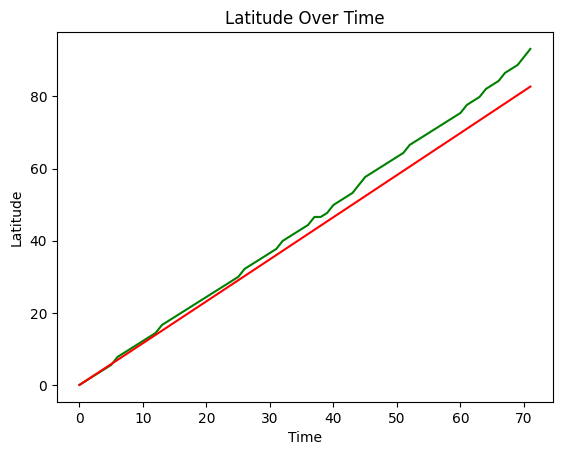

In [128]:
# 초기값 설정
initial_latitude = 0

# 실제 latitude 추정치 계산
test1_Latitude_predicted = [initial_latitude]
for change in test1_predicted_latitude:
    test1_new_latitude = test1_Latitude_predicted[-1] + change
    test1_Latitude_predicted.append(test1_new_latitude)

# 실제 latitude 추정치 계산
test1_Latitude_actual = [initial_latitude]
for change in test1_actual_latitude:
    test1_new_latitude = test1_Latitude_actual[-1] + change
    test1_Latitude_actual.append(test1_new_latitude)

# 시각화
plt.plot(test1_Latitude_actual, label='Actual', c='g')
plt.plot(test1_Latitude_predicted, label='Predicted', c='r')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.title('Latitude Over Time')
plt.show()

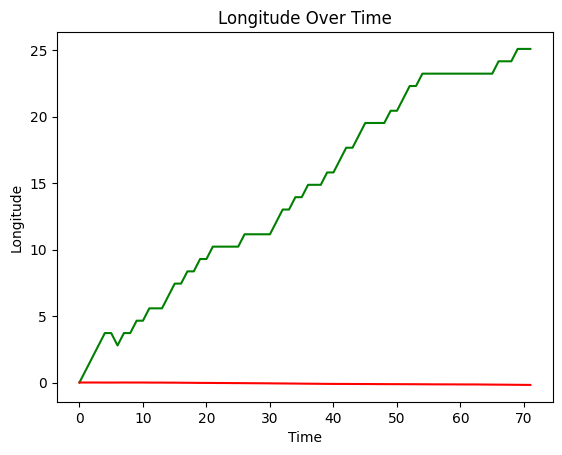

In [129]:
# 초기값 설정
initial_longitude = 0

# 실제 latitude 추정치 계산
test1_Longitude_predicted = [initial_longitude]
for change in test1_predicted_longitude:
    test1_new_longitude = test1_Longitude_predicted[-1] + change
    test1_Longitude_predicted.append(test1_new_longitude)

# 실제 latitude 추정치 계산
test1_Longitude_actual = [initial_longitude]
for change in test1_actual_longitude:
    test1_new_longitude = test1_Longitude_actual[-1] + change
    test1_Longitude_actual.append(test1_new_longitude)

# 시각화
plt.plot(test1_Longitude_actual, label='Actual', c='g')
plt.plot(test1_Longitude_predicted, label='Predicted', c='r')
plt.xlabel('Time')
plt.ylabel('Longitude')
plt.title('Longitude Over Time')
plt.show()

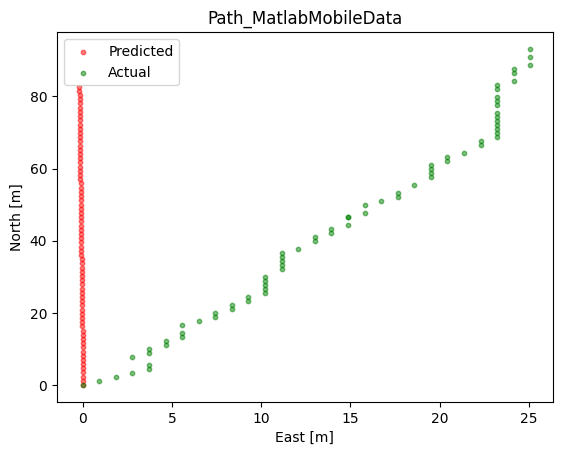

In [130]:
plt.scatter(x=test1_Longitude_predicted, y=test1_Latitude_predicted, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=test1_Longitude_actual, y=test1_Latitude_actual, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('Path_MatlabMobileData')
plt.legend()
plt.show()

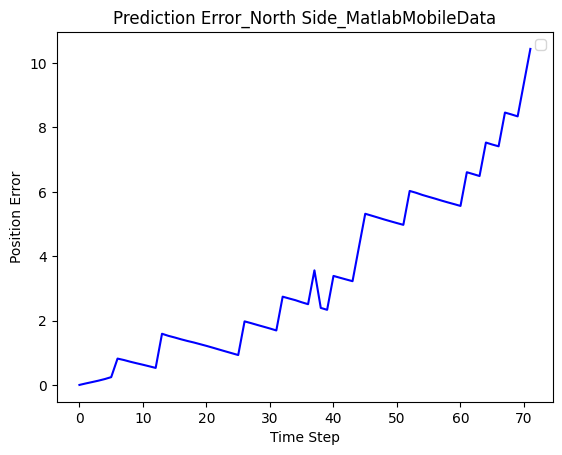

In [131]:
test1_Longitude_actual = np.array(test1_Longitude_actual)
test1_Latitude_actual = np.array(test1_Latitude_actual)
test1_Longitude_predicted = np.array(test1_Longitude_predicted)
test1_Latitude_predicted = np.array(test1_Latitude_predicted)

test1_errors_latitude = np.sqrt((test1_Latitude_actual - test1_Latitude_predicted) ** 2)

test1_time_steps = np.arange(len(test1_errors_latitude))

plt.plot(test1_time_steps, test1_errors_latitude, color='b')
plt.xlabel('Time Step')
plt.ylabel('Position Error')
plt.title('Prediction Error_North Side_MatlabMobileData')
plt.legend()
plt.show()

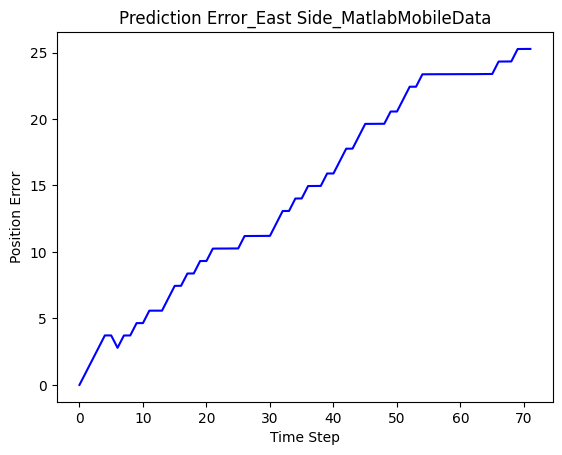

In [207]:
test1_errors_longitude = np.sqrt((test1_Longitude_actual - test1_Longitude_predicted) ** 2)

test1_time_steps = np.arange(len(test1_errors_longitude))

plt.plot(test1_time_steps, test1_errors_longitude, color='b')
plt.xlabel('Time Step')
plt.ylabel('Position Error')
plt.title('Prediction Error_East Side_MatlabMobileData')
plt.show()

**TEST 2. 120122 NCLT robot data**

**예측 구간: 70060 ~ 73060 (30s)**

In [266]:
df_Course2 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['Latitude', 'Longitude', 'Altitude'])

TEST2_timestamps = 3060
window_size_TEST2 = 60
start_point_TEST2 = 70000
num_windows_TEST2 = TEST2_timestamps - window_size_TEST2 + 1

df_TEST2 = df_GPS_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2 = df_TEST2[['Latitude', 'Longitude', 'Altitude']]

df_Accel_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST2 = df_Accel_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Accel_x_NED'] = df_TEST2['Accel_x_NED']
data_TEST2['Accel_y_NED'] = df_TEST2['Accel_y_NED']
data_TEST2['Accel_z_NED'] = df_TEST2['Accel_z_NED']

df_Euler_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST2 = df_Euler_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Euler_x'] = df_TEST2['Euler_x']
data_TEST2['Euler_y'] = df_TEST2['Euler_y']
data_TEST2['Euler_z'] = df_TEST2['Euler_z']

df_TEST2 = df_Course2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Gyro_x'] = df_TEST2['Gyro_x']
data_TEST2['Gyro_y'] = df_TEST2['Gyro_y']
data_TEST2['Gyro_z'] = df_TEST2['Gyro_z']
data_TEST2.tail()

,Latitude,Longitude,Altitude,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
73055,-5.7298,-9.4952,28.646,-0.133930,-0.114990,9.8086,168.20,-0.63546,-0.33174,-0.026288,0.064467,0.038812
73056,-5.7298,-9.4952,28.629,-0.115080,-0.094835,9.8059,168.44,-0.47581,-0.31130,-0.029793,0.048725,0.026436
73057,-5.7298,-9.4953,28.613,-0.104460,-0.072229,9.8058,168.62,-0.33243,-0.33823,-0.029636,0.036858,0.016007
73058,-5.7298,-9.4954,28.601,-0.089284,-0.044439,9.8088,168.76,-0.14870,-0.36114,-0.018065,0.017090,-0.026032
73059,-5.7300,-9.4956,28.593,-0.078892,-0.014507,9.8121,168.92,0.02873,-0.41402,-0.004563,-0.002577,-0.032112


In [267]:
delta_data_TEST2 = data_TEST2.diff(axis=0)
delta_latitude_TEST2 = delta_data_TEST2['Latitude']
delta_longitude_TEST2 = delta_data_TEST2['Longitude']
delta_altitude_TEST2 = delta_data_TEST2['Altitude']

shifted_TEST2 = delta_data_TEST2[['Latitude', 'Longitude', 'Altitude']].copy()
shifted_TEST2['Pred_Lat'] = shifted_TEST2['Latitude'].shift(-window_size_TEST2)
shifted_TEST2['Pred_Lon'] = shifted_TEST2['Longitude'].shift(-window_size_TEST2)
shifted_TEST2['Pred_Alt'] = shifted_TEST2['Altitude'].shift(-window_size_TEST2)

shifted_TEST2['Pred_Lat'].fillna(method='ffill', inplace = True)
shifted_TEST2['Pred_Lon'].fillna(method='ffill', inplace = True)
shifted_TEST2['Pred_Alt'].fillna(method='ffill', inplace = True)

In [268]:
train_X_TEST2 =  data_TEST2[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST2 = train_X_TEST2.astype(np.float32)

windowed_data_TEST2 = np.zeros((num_windows_TEST2, window_size_TEST2, 9), dtype = np.float32)

for i in range(num_windows_TEST2):
    windowed_data_TEST2[i] = train_X_TEST2[i:i+window_size_TEST2]

train_y_TEST2=shifted_TEST2[['Pred_Lat', 'Pred_Lon', 'Pred_Alt']][:num_windows_TEST2]

x_data_TEST2 = windowed_data_TEST2
x_data_TEST2 = np.array(x_data_TEST2)
y_data_TEST2 = train_y_TEST2.values

print(x_data_TEST2.shape)
print(y_data_TEST2.shape)

(3001, 60, 9)
(3001, 3)


In [269]:
x_data_TEST2 = x_data_TEST2.astype(np.float32)
y_data_TEST2 = y_data_TEST2.astype(np.float32)

sc_TEST2 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST2 = x_data_TEST2.reshape(-1, x_data_TEST2.shape[-1])
y_data_2d_TEST2 = y_data_TEST2.reshape(-1, y_data_TEST2.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST2 = sc_TEST2.fit_transform(x_data_2d_TEST2)
new_y_data_2d_TEST2 = sc_TEST2.fit_transform(y_data_2d_TEST2)

# 다시 3D로 변환
new_x_data_TEST2 = new_x_data_2d_TEST2.reshape(x_data_TEST2.shape)
new_y_data_TEST2 = new_y_data_2d_TEST2.reshape(y_data_TEST2.shape)

print(new_x_data_TEST2.shape)
print(new_y_data_TEST2.shape)

(3001, 60, 9)
(3001, 3)


In [270]:
if __name__ == "__main__":

    y_pred_TEST2 = model.predict(new_x_data_TEST2)

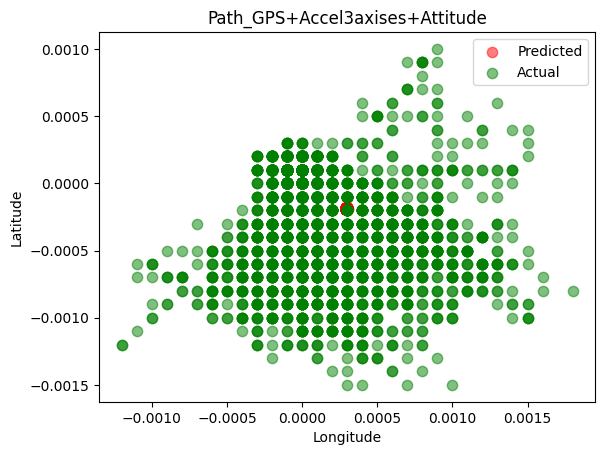

In [271]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST2 = np.array(y_pred_TEST2)
new_y_data_array_TEST2 = np.array(new_y_data_TEST2)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST2 = y_preds_array_TEST2.reshape(-1, y_preds_array_TEST2.shape[-1])
new_y_data_flat_TEST2 = new_y_data_array_TEST2.reshape(-1, new_y_data_array_TEST2.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_lat_lon_TEST2 = sc_TEST2.inverse_transform(y_preds_flat_TEST2)
rescaled_y_test_actual_lat_lon_TEST2 = sc_TEST2.inverse_transform(new_y_data_flat_TEST2)

# 위도와 경도값만 가져오기
predicted_latitude_TEST2 = rescaled_y_preds_lat_lon_TEST2[:, 0]
predicted_longitude_TEST2 = rescaled_y_preds_lat_lon_TEST2[:, 1]

actual_latitude_TEST2 = rescaled_y_test_actual_lat_lon_TEST2[:, 0]
actual_longitude_TEST2 = rescaled_y_test_actual_lat_lon_TEST2[:, 1]

plt.scatter(x=predicted_longitude_TEST2, y=predicted_latitude_TEST2, label='Predicted', c='r', s=55, alpha=0.5)
plt.scatter(x=actual_longitude_TEST2, y=actual_latitude_TEST2, label='Actual', c='g', s=55, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path_GPS+Accel3axises+Attitude')
plt.legend()
plt.show()

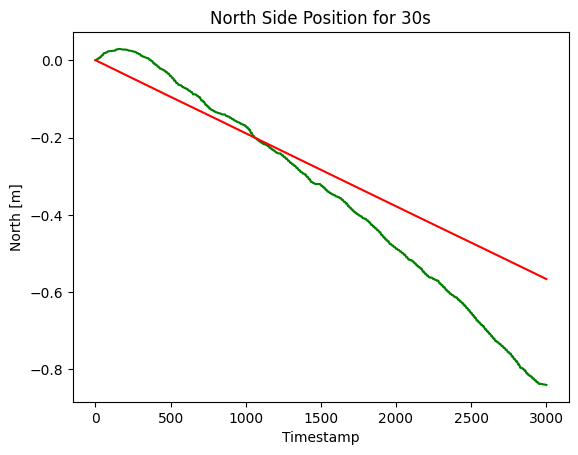

In [272]:
# 초기값 설정
initial_latitude = 0

# 실제 latitude 추정치 계산
Latitude_predicted_TEST2 = [initial_latitude]
for change in predicted_latitude_TEST2:
    new_latitude_TEST2 = Latitude_predicted_TEST2[-1] + change
    Latitude_predicted_TEST2.append(new_latitude_TEST2)

# 실제 latitude 추정치 계산
Latitude_actual_TEST2 = [initial_latitude]
for change in actual_latitude_TEST2:
    new_latitude_TEST2 = Latitude_actual_TEST2[-1] + change
    Latitude_actual_TEST2.append(new_latitude_TEST2)

# 시각화
plt.plot(Latitude_actual_TEST2, label='Actual', c='g')
plt.plot(Latitude_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

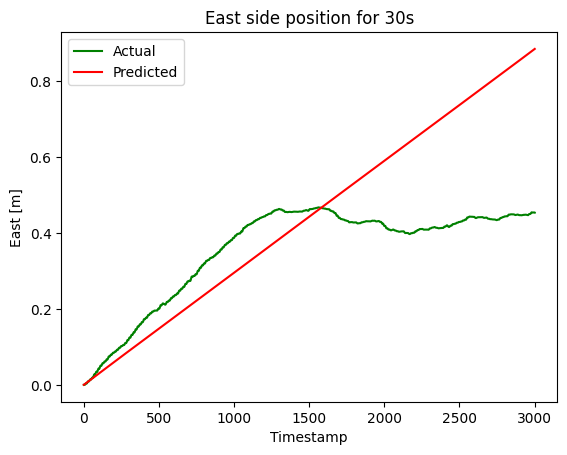

In [273]:
# 초기값 설정
initial_longitude = 0

# 실제 latitude 추정치 계산
Longitude_predicted_TEST2 = [initial_longitude]
for change in predicted_longitude_TEST2:
    new_longitude_TEST2 = Longitude_predicted_TEST2[-1] + change
    Longitude_predicted_TEST2.append(new_longitude_TEST2)

# 실제 latitude 추정치 계산
Longitude_actual_TEST2 = [initial_longitude]
for change in actual_longitude_TEST2:
    new_longitude_TEST2 = Longitude_actual_TEST2[-1] + change
    Longitude_actual_TEST2.append(new_longitude_TEST2)

# 시각화
plt.plot(Longitude_actual_TEST2, label='Actual', c='g')
plt.plot(Longitude_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

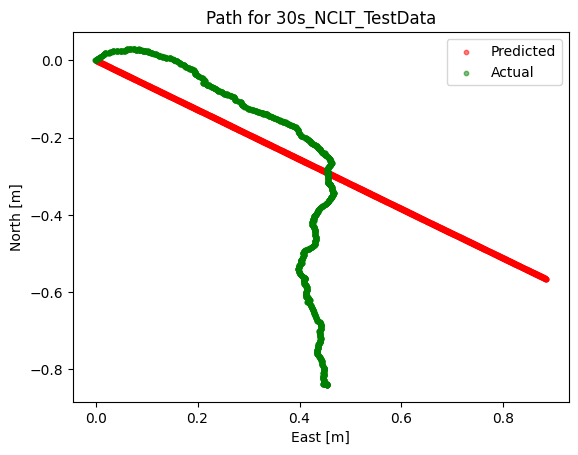

In [274]:
plt.scatter(x=Longitude_predicted_TEST2, y=Latitude_predicted_TEST2, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=Longitude_actual_TEST2, y=Latitude_actual_TEST2, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

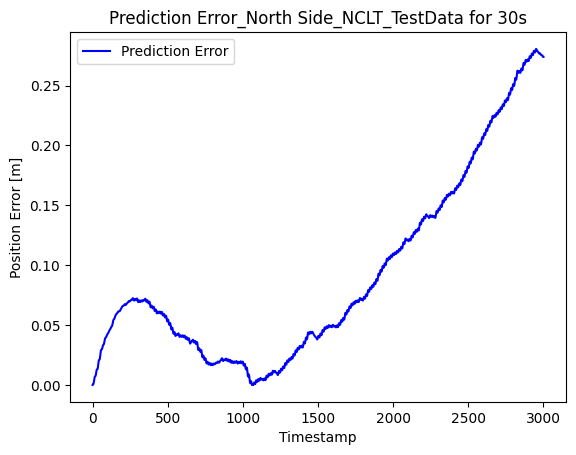

In [275]:
Longitude_actual_TEST2 = np.array(Longitude_actual_TEST2)
Latitude_actual_TEST2 = np.array(Latitude_actual_TEST2)
Longitude_predicted_TEST2 = np.array(Longitude_predicted_TEST2)
Latitude_predicted_TEST2 = np.array(Latitude_predicted_TEST2)

errors_TEST2 = np.sqrt((Latitude_actual_TEST2 - Latitude_predicted_TEST2) ** 2)

time_steps_TEST2 = np.arange(len(errors_TEST2))

plt.plot(time_steps_TEST2, errors_TEST2, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

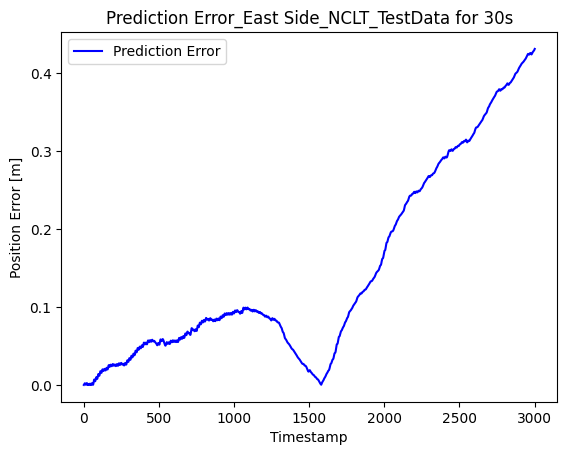

In [276]:
Longitude_actual_TEST2 = np.array(Longitude_actual_TEST2)
Latitude_actual_TEST2 = np.array(Latitude_actual_TEST2)
Longitude_predicted_TEST2 = np.array(Longitude_predicted_TEST2)
Latitude_predicted_TEST2 = np.array(Latitude_predicted_TEST2)

errors_TEST2 = np.sqrt((Longitude_actual_TEST2 - Longitude_predicted_TEST2) ** 2)

time_steps_TEST2 = np.arange(len(errors_TEST2))

plt.plot(time_steps_TEST2, errors_TEST2, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

**TEST 3. 120122 NCLT robot data**

**예측 구간: 100560 ~103560 (30s)**

In [195]:
df_Course3 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['Latitude', 'Longitude', 'Altitude'])

TEST3_timestamps = 3060
window_size_TEST3 = 60
start_point_TEST3 = 100500
num_windows_TEST3 = TEST3_timestamps - window_size_TEST3 + 1

df_TEST3 = df_GPS_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3 = df_TEST3[['Latitude', 'Longitude', 'Altitude']]

df_Accel_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST3 = df_Accel_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Accel_x_NED'] = df_TEST3['Accel_x_NED']
data_TEST3['Accel_y_NED'] = df_TEST3['Accel_y_NED']
data_TEST3['Accel_z_NED'] = df_TEST3['Accel_z_NED']

df_Euler_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST3 = df_Euler_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Euler_x'] = df_TEST3['Euler_x']
data_TEST3['Euler_y'] = df_TEST3['Euler_y']
data_TEST3['Euler_z'] = df_TEST3['Euler_z']

df_TEST3 = df_Course3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Gyro_x'] = df_TEST3['Gyro_x']
data_TEST3['Gyro_y'] = df_TEST3['Gyro_y']
data_TEST3['Gyro_z'] = df_TEST3['Gyro_z']
data_TEST3.tail()

,Latitude,Longitude,Altitude,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
103555,-3.1222,-13.467,11.598,-1.00390,0.32500,9.7578,14.709,-1.5230,-5.9658,0.127067,0.010444,-0.124526
103556,-3.1222,-13.467,11.597,-0.97249,0.30586,9.7637,14.538,-1.5060,-5.7494,0.131689,0.015507,-0.110271
103557,-3.1223,-13.467,11.597,-0.92036,0.27464,9.7714,14.231,-1.4753,-5.3932,0.118934,0.021660,-0.071807
103558,-3.1223,-13.467,11.597,-0.87519,0.24970,9.7765,13.985,-1.4390,-5.0927,0.100668,0.016702,-0.047060
103559,-3.1224,-13.467,11.598,-0.82863,0.22409,9.7802,13.725,-1.4013,-4.7841,0.086562,0.021349,-0.020853


In [196]:
delta_data_TEST3 = data_TEST3.diff(axis=0)
delta_latitude_TEST3 = delta_data_TEST3['Latitude']
delta_longitude_TEST3 = delta_data_TEST3['Longitude']
delta_altitude_TEST3 = delta_data_TEST3['Altitude']

shifted_TEST3 = delta_data_TEST3[['Latitude', 'Longitude', 'Altitude']].copy()
shifted_TEST3['Pred_Lat'] = shifted_TEST3['Latitude'].shift(-window_size_TEST3)
shifted_TEST3['Pred_Lon'] = shifted_TEST3['Longitude'].shift(-window_size_TEST3)
shifted_TEST3['Pred_Alt'] = shifted_TEST3['Altitude'].shift(-window_size_TEST3)

shifted_TEST3['Pred_Lat'].fillna(method='ffill', inplace = True)
shifted_TEST3['Pred_Lon'].fillna(method='ffill', inplace = True)
shifted_TEST3['Pred_Alt'].fillna(method='ffill', inplace = True)

In [197]:
train_X_TEST3 =  data_TEST3[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST3 = train_X_TEST3.astype(np.float32)

windowed_data_TEST3 = np.zeros((num_windows_TEST3, window_size_TEST3, 9), dtype = np.float32)

for i in range(num_windows_TEST3):
    windowed_data_TEST3[i] = train_X_TEST3[i:i+window_size_TEST3]

train_y_TEST3=shifted_TEST3[['Pred_Lat', 'Pred_Lon', 'Pred_Alt']][:num_windows_TEST3]

x_data_TEST3 = windowed_data_TEST3
x_data_TEST3 = np.array(x_data_TEST3)
y_data_TEST3 = train_y_TEST3.values

print(x_data_TEST3.shape)
print(y_data_TEST3.shape)

(3001, 60, 9)
(3001, 3)


In [198]:
x_data_TEST3 = x_data_TEST3.astype(np.float32)
y_data_TEST3 = y_data_TEST3.astype(np.float32)

sc_TEST3 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST3 = x_data_TEST3.reshape(-1, x_data_TEST3.shape[-1])
y_data_2d_TEST3 = y_data_TEST3.reshape(-1, y_data_TEST3.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST3 = sc_TEST3.fit_transform(x_data_2d_TEST3)
new_y_data_2d_TEST3 = sc_TEST3.fit_transform(y_data_2d_TEST3)

# 다시 3D로 변환
new_x_data_TEST3 = new_x_data_2d_TEST3.reshape(x_data_TEST3.shape)
new_y_data_TEST3 = new_y_data_2d_TEST3.reshape(y_data_TEST3.shape)

print(new_x_data_TEST3.shape)
print(new_y_data_TEST3.shape)

(3001, 60, 9)
(3001, 3)


In [199]:
if __name__ == "__main__":

    y_pred_TEST3 = model.predict(new_x_data_TEST3)

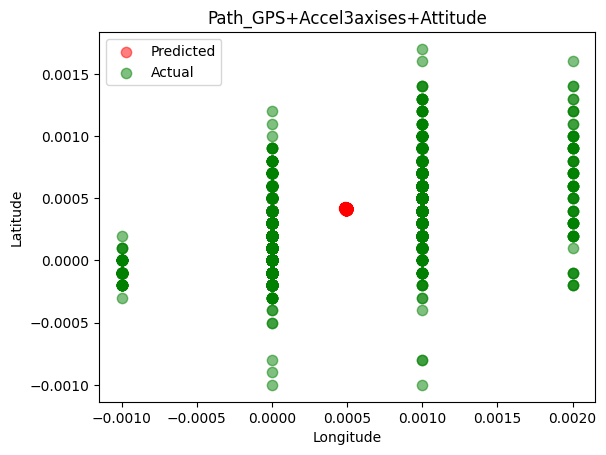

In [206]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST3 = np.array(y_pred_TEST3)
new_y_data_array_TEST3 = np.array(new_y_data_TEST3)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST3 = y_preds_array_TEST3.reshape(-1, y_preds_array_TEST3.shape[-1])
new_y_data_flat_TEST3 = new_y_data_array_TEST3.reshape(-1, new_y_data_array_TEST3.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_lat_lon_TEST3 = sc_TEST3.inverse_transform(y_preds_flat_TEST3)
rescaled_y_test_actual_lat_lon_TEST3 = sc_TEST3.inverse_transform(new_y_data_flat_TEST3)

# 위도와 경도값만 가져오기
predicted_latitude_TEST3 = rescaled_y_preds_lat_lon_TEST3[:, 0]
predicted_longitude_TEST3 = rescaled_y_preds_lat_lon_TEST3[:, 1]

actual_latitude_TEST3 = rescaled_y_test_actual_lat_lon_TEST3[:, 0]
actual_longitude_TEST3 = rescaled_y_test_actual_lat_lon_TEST3[:, 1]

plt.scatter(x=predicted_longitude_TEST3, y=predicted_latitude_TEST3, label='Predicted', c='r', s=55, alpha=0.5)
plt.scatter(x=actual_longitude_TEST3, y=actual_latitude_TEST3, label='Actual', c='g', s=55, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path_GPS+Accel3axises+Attitude')
plt.legend()
plt.show()

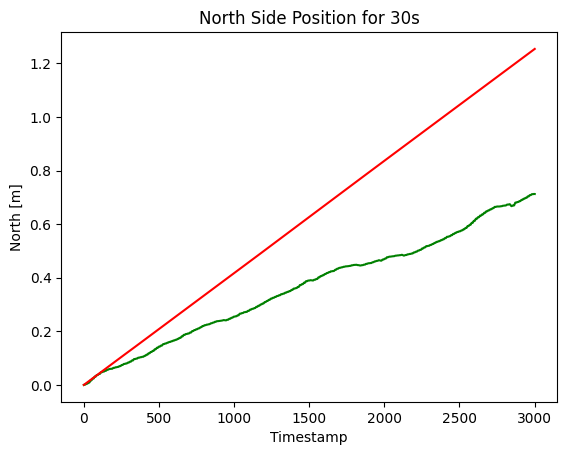

In [201]:
# 초기값 설정
initial_latitude = 0

# 실제 latitude 추정치 계산
Latitude_predicted_TEST3 = [initial_latitude]
for change in predicted_latitude_TEST3:
    new_latitude_TEST3 = Latitude_predicted_TEST3[-1] + change
    Latitude_predicted_TEST3.append(new_latitude_TEST3)

# 실제 latitude 추정치 계산
Latitude_actual_TEST3 = [initial_latitude]
for change in actual_latitude_TEST3:
    new_latitude_TEST3 = Latitude_actual_TEST3[-1] + change
    Latitude_actual_TEST3.append(new_latitude_TEST3)

# 시각화
plt.plot(Latitude_actual_TEST3, label='Actual', c='g')
plt.plot(Latitude_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

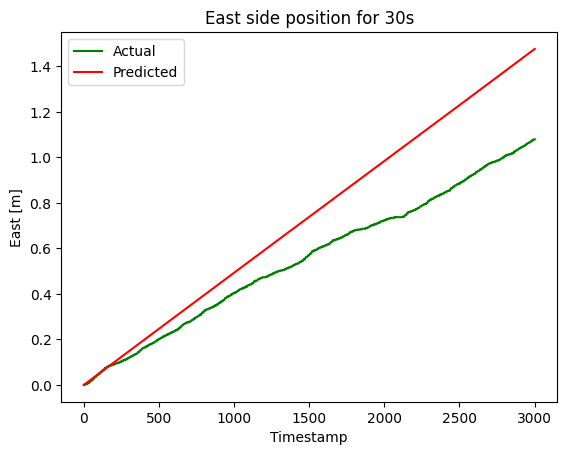

In [202]:
# 초기값 설정
initial_longitude = 0

# 실제 latitude 추정치 계산
Longitude_predicted_TEST3 = [initial_longitude]
for change in predicted_longitude_TEST3:
    new_longitude_TEST3 = Longitude_predicted_TEST3[-1] + change
    Longitude_predicted_TEST3.append(new_longitude_TEST3)

# 실제 latitude 추정치 계산
Longitude_actual_TEST3 = [initial_longitude]
for change in actual_longitude_TEST3:
    new_longitude_TEST3 = Longitude_actual_TEST3[-1] + change
    Longitude_actual_TEST3.append(new_longitude_TEST3)

# 시각화
plt.plot(Longitude_actual_TEST3, label='Actual', c='g')
plt.plot(Longitude_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

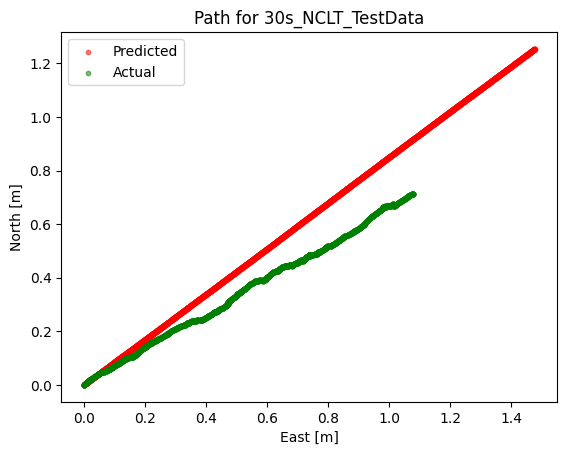

In [203]:
plt.scatter(x=Longitude_predicted_TEST3, y=Latitude_predicted_TEST3, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=Longitude_actual_TEST3, y=Latitude_actual_TEST3, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

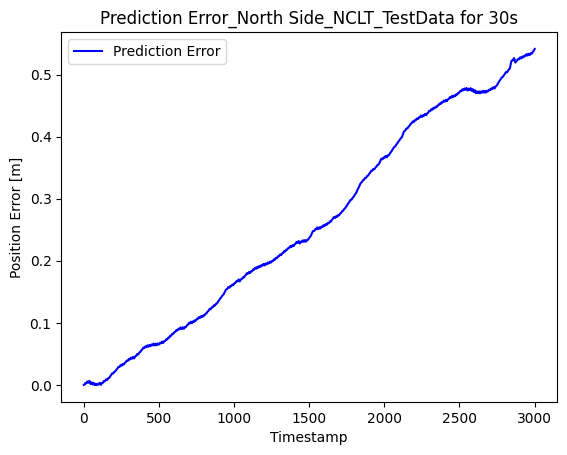

In [204]:
Longitude_actual_TEST3 = np.array(Longitude_actual_TEST3)
Latitude_actual_TEST3 = np.array(Latitude_actual_TEST3)
Longitude_predicted_TEST3 = np.array(Longitude_predicted_TEST3)
Latitude_predicted_TEST3 = np.array(Latitude_predicted_TEST3)

errors_TEST3 = np.sqrt((Latitude_actual_TEST3 - Latitude_predicted_TEST3) ** 2)

time_steps_TEST3 = np.arange(len(errors_TEST3))

plt.plot(time_steps_TEST3, errors_TEST3, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

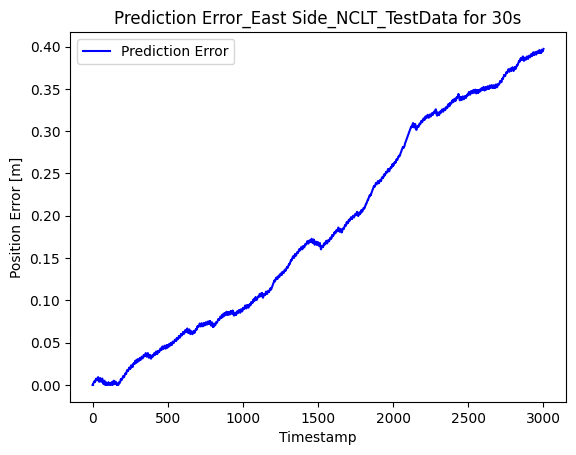

In [205]:
Longitude_actual_TEST3 = np.array(Longitude_actual_TEST3)
Latitude_actual_TEST3 = np.array(Latitude_actual_TEST3)
Longitude_predicted_TEST3 = np.array(Longitude_predicted_TEST3)
Latitude_predicted_TEST3 = np.array(Latitude_predicted_TEST3)

errors_TEST3 = np.sqrt((Longitude_actual_TEST3 - Longitude_predicted_TEST3) ** 2)

time_steps_TEST3 = np.arange(len(errors_TEST3))

plt.plot(time_steps_TEST3, errors_TEST3, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()